Note, this is an *example* solution. There is more that one way to do this, so other solutions can be equally valid. 


## World Ocean Atlas

NOAA's [World Ocean Atlas](https://www.nodc.noaa.gov/OC5/WOA09/netcdf_data.html) (WOA) provides open-access gridded data of temperature, salinity and other ocean parameters.  
It is a set of objectively analyzed climatological fields at standard depth levels for annual, seasonal, and monthly compositing periods. It also includes associated statistical fields of observed oceanographic profile data.

WOA is available over a variety of resolutions (5$^\circ$, 1$^\circ$ or 1/4$^\circ$grid). It is also available in different data formats.  
If you choose to analyse these data, we suggest that you follow these initial steps:

* download 5$^\circ$ data of temperature and oxygen, in NetCDF format. 
* plot the sea surface data (or depth of choice) on a global map 
    * do not use jet/rainbow colormap!
* calculate an average depth profile and plot it beside the map

Bonus step: 
* Rather than creating two sections of code for each variable, can you create a function that will produce plots for either the temperature or oxygen variables?  

In [1]:
# Hint: 
# To download temperature data into xarray, you can use the following e.g. 
# WOA_temp = xr.open_dataset('https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/decav/5deg/woa18_decav_t00_5d.nc', decode_times=False)
# decode_times=False is needed when xarray cannot process dates on import (you will see an error if use without). 
# To access oxygen, you can use the following URL:
# https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc



Import packages used below: 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs

Here we use xarray to import the remote dataset (as suggested in the hint above): 

In [3]:
WOA_temp_path = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/decav/5deg/woa18_decav_t00_5d.nc'
WOA_o2_path = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'

WOA_temp = xr.open_dataset(WOA_temp_path, decode_times=False)
WOA_o2 = xr.open_dataset(WOA_o2_path, decode_times=False)

The first time you import a dataset you likely want to print the dataset, to check its contents:

In [4]:
# check what our data looks like
#print(WOA_temp)

Let's create a simple function to extract the variables we're interested in.  
This returns: 
* required coordinates: lat, lon, depth
* surface level (map)
* depth-profile (averaged over latitude and longitude)
    

In [5]:
# Extract the data needed for plotting
def read_map_profile(data, varname):
    '''
    Extract variable of interest from given xarray dataset. 
    Input: 
    data = xarray dataset
    varname = string, variable name to be extracted.
    Return: 
    lon, lat, depth = coordinates of variable
    var_map = surface layer of variable
    vap_profile = depth-profile of variable, averaged over latitude and longitude

    '''
    
    lat = data.coords['lat']
    lon = data.coords['lon']
    depth = data.coords['depth']

    var_map = data[varname].isel(depth=0, time=0) # Note: although it's a climatology, there is a time axis. 

    var_profile = data[varname].mean(['lat', 'lon', 'time']) # average over lat, lon, time, to be left with 1D (vary by depth)

    return lon, lat, depth, var_map, var_profile
    

In [6]:
# Check that the function works? 
lon, lat, depth, temp_map, temp_profile = read_map_profile(WOA_temp, 't_mn')

#temp_map.plot()

#temp_profile.plot()

Now let's create a map, to create nice global figures.

This function is edited slightly from those in the cartopy exercises, to allow for a specified width of subplot (gridspec).

In [7]:
def plot_map(fig, gridspec):
    '''
    Create global map with added coastline (scale = 50m). 
    Input:
    pos = position of subplot axes; three integers e.g. 111 (for one subplot per figure)
    Output: 
    ax = axis handle of map
    '''
    ax = fig.add_subplot(gridspec, projection=ccrs.PlateCarree())
    ax.set(xlim=[-180,180], ylim=[-89,89], transform =ccrs.PlateCarree() )

    gl = ax.gridlines(draw_labels=False)
    
    feature = cartopy.feature.NaturalEarthFeature(name='coastline',
                                              category='physical',
                                              scale='50m',
                                              edgecolor='0.5',
                                              facecolor='0.8')
    ax.add_feature(feature)

    return ax
    

For now, let's just plot the temperature data as requested: 
* Map of chosen level (here surface)
* Depth profile. 

As noted above, we use the gridspec module to specify a ratio of width of subplots. More info on this is available [here](https://matplotlib.org/tutorials/intermediate/gridspec.html). 

Text(0.5, 0, 'Global average temperature [deg C]')

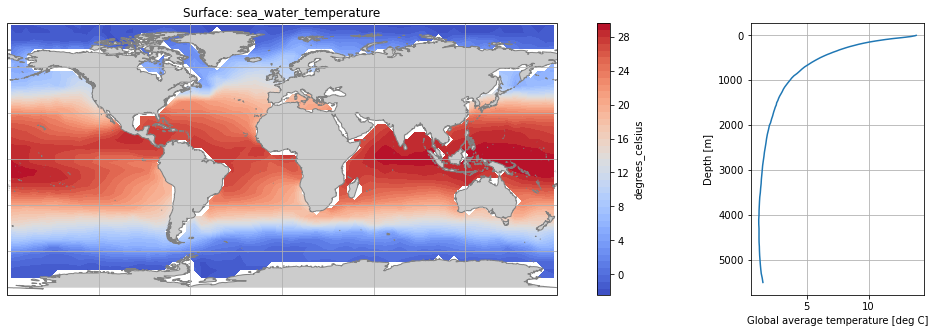

In [8]:
# Create the figure 
# To set ratio of subplot positions, can use gridspec
fig = plt.figure(figsize=(18, 5))
ratio = 4
gs = gridspec.GridSpec(ncols=ratio+1, nrows=1, figure=fig)

ax1 = plot_map(fig, gs[0,:ratio])

# draw filled contours onto the map axes (ax).
h = ax1.contourf(lon, lat, temp_map, 50, cmap='coolwarm', transform=ccrs.PlateCarree())

# add colorbar.
cbar = fig.colorbar(h)
# with unit label
cbar.set_label(temp_map.units)

# add a title
ax1.set_title(f'Surface: {temp_map.standard_name}');

# Add subplot of temperature profile. 
ax2 = fig.add_subplot(gs[0,ratio])
ax2.plot(temp_profile, depth)
ax2.grid()
ax2.invert_yaxis()

ax2.set_ylabel('Depth [m]')
ax2.set_xlabel('Global average temperature [deg C]')


Now we're happy with this, let's put the code into a function, to make it useable for both the temperature and oxygen data...  
(or whatever other WOA data you might want to investigate)

In [9]:
def plot_global(data, varname, fs=(18, 5)):
    '''
    Plot figure of global map and vertical profile of given dataset. 
    Input: 
    data = xarray dataset
    varname = variable name from dataset
    fs = figure size, optional, default = (18,5)
    Output: 
    fig = figure handle
    ax1 = map handle
    ax2 = profile handle
    
    Function dependent on two functions defined above: 
    read_map_profile
    plot_map
    '''
    lon, lat, depth, var_map, var_profile = read_map_profile(data, varname)
    
    fig = plt.figure(figsize=fs)
    ratio = 4
    gs = gridspec.GridSpec(ncols=ratio+1, nrows=1, figure=fig)

    ax1 = plot_map(fig, gs[0,:ratio])

    # draw filled contours onto the map axes (ax).
    h = ax1.contourf(lon, lat, var_map, 50, cmap='coolwarm', transform=ccrs.PlateCarree())

    # add colorbar.
    cbar = fig.colorbar(h)
    # with unit label
    cbar.set_label(var_map.units)

    # add a title
    ax1.set_title(f'Surface: {var_map.standard_name}');

    # Add subplot of temperature profile. 
    ax2 = fig.add_subplot(gs[0,ratio])
    ax2.plot(var_profile, depth)
    ax2.grid()
    ax2.invert_yaxis()
    
    ax2.set_ylabel('Depth [m]')
    ax2.set_xlabel(f'Global average [{var_map.units}]')
    
    return fig, ax1, ax2



We check that it works for temperature again: 

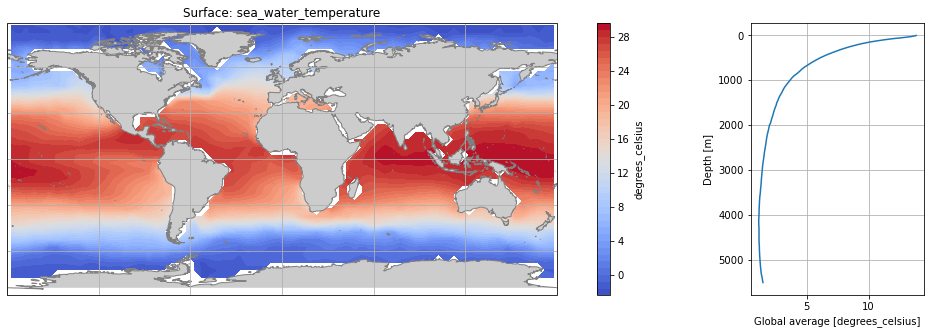

In [10]:
fig, ax1, ax2 = plot_global(WOA_temp, 't_mn')

And finally, use for the oxygen data as well: 

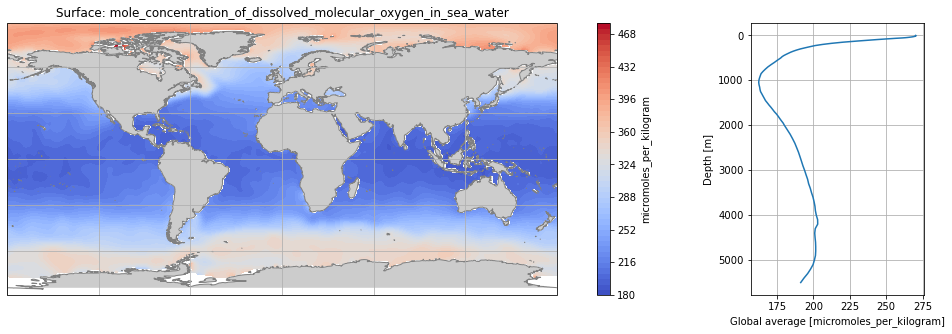

In [11]:
fig, ax1, ax2 = plot_global(WOA_o2, 'o_an')